In [ ]:
#|default_exp stitcher

# Automated tile grid stitching - how it works 

> Pff, stitching multiple tiles turned out to be a much harder problem then I thought...

*You can find a lot of tutorials how to do simple image stitching using two photos and that is no problem. But what to do when I want to make a panorama from 4-6 images or more?* 

This question posted on [stackoverflow](https://stackoverflow.com/questions/24563173/stitch-multiple-images-using-opencv-python), this [article](https://web.archive.org/web/20140115053733/http://cs.bath.ac.uk:80/brown/papers/ijcv2007.pdf), make clear that robust automated stitching of multiple images presents a much harder problem. In case you are interested to learn how this works. Here follows a brief description of the consecutive steps of automated tile stitching algorithm implemented in `gridstitcher`. 

To get started you need to obtain a list of the tile image files. This is best done with the operating system independent standard package `pathlib`. Let's also already import `matplotlib` here to inspect the result below. 

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt 

In [ ]:
tiles_dir = Path('/home/frank/Work/Werknummers/2024-811_Falnama/data/Weimar-IRR_1600nm/71803-02_IRR 1600 nm/') 
im_files = sorted(tiles_dir.glob('*.tif'))
len(im_files) 

36

To perform the consecutive steps of the automated registration of the image tiles we first need to import the `Tilegrid` class. 

In [ ]:
from gridstitcher import Tilegrid

Tile registration is performed in three consecutive steps. In **step 1** we instantiate a `Tilegrid` object with a sorted list of image files, and specify the number of rows and columns for the grid. 

Initializing regular 6x6 tile grid...


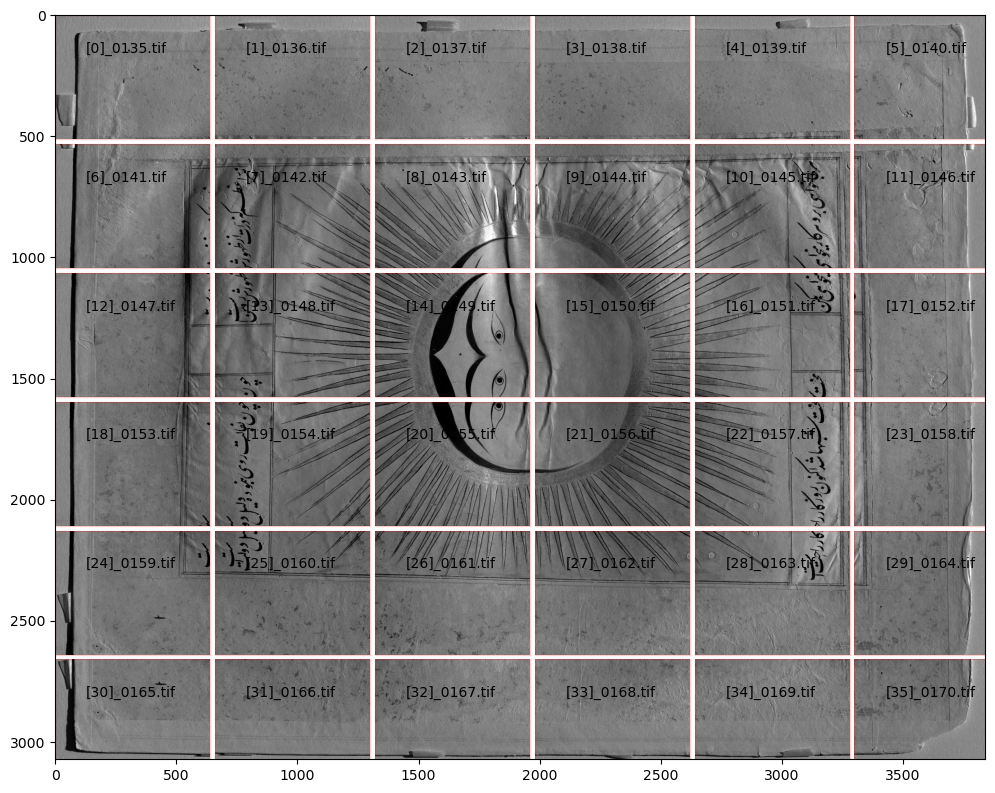

In [ ]:
tg = Tilegrid(im_files, nrows=6, ncols=6) # 1) load images 

In **step 2** the [SIFT-RANSAC algorithm](https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html) is used to obtain pairs of points that match corresponding features on adjacent tiles. These point pairs are computed and plotted with the `Tilegrid.get_ransac_pair_points()` method. 

Detecting corresponding SIFT RANSAC point pairs...
Could not detect corresponding feature points in tile pair [2, 3] 
Could not detect corresponding feature points in tile pair [3, 4] 


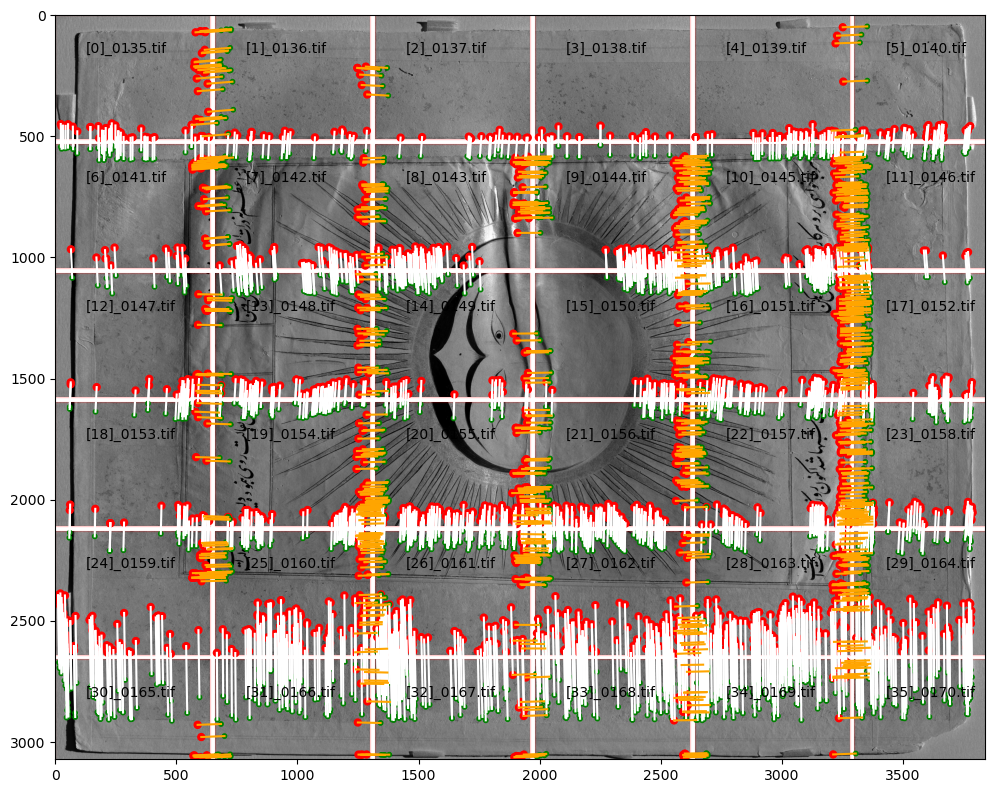

In [ ]:
tg.get_ransac_pair_points()

For this specific example warnings are given that in the tile overlap pairs `[2, 3]` and `[3, 4]` no corresponding feature points were detected. The absence of overlap pair is not a problem as long as each tile is connected at least with one other tile. 

In **step 3** the sum of distances for all RANSAC point pairs in the tile grid is minimized by shifting each individual tile left-right and up-down. Note that we do not rotate, scale or warp the images.  

Registering tiles...


/home/frank/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 4536.434504
         Iterations: 115
         Function evaluations: 15487
         Gradient evaluations: 212


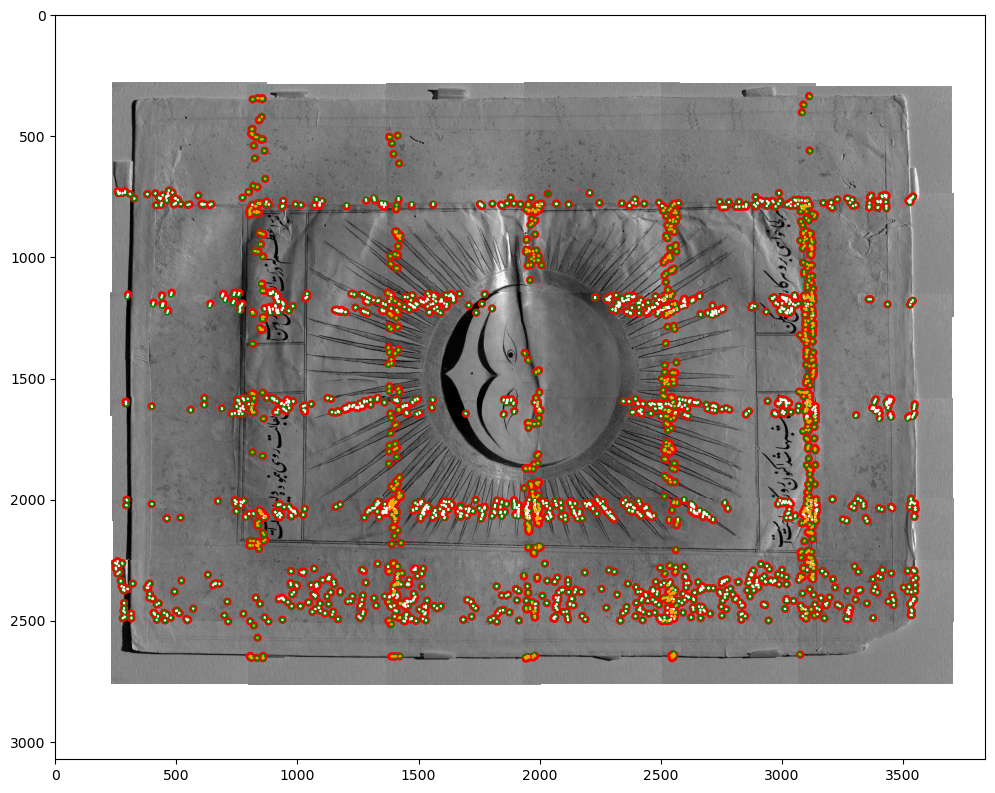

In [ ]:
tg.register_tiles()                          # 3) shift tiles to optimal overlap  

In our example we observe that the registration of the individual tiles is successful. To make the composite image array use the method `Tilegrid.make_stitched()`. If you specify the option `save_to=` you can automatically  save to an image file. 

In [ ]:
stitched_im = tg.make_stitched(save_to='../downloads/stitched.png')

Saving image to: ../downloads/stitched.png


Let's inspect our stitched mosaic image. 

<matplotlib.image.AxesImage>

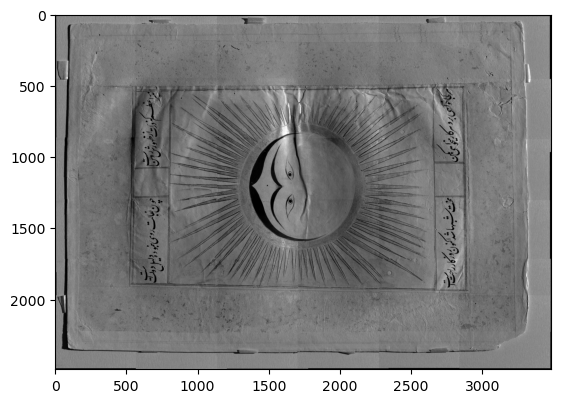

In [ ]:
fig, ax = plt.subplots()
ax.imshow(stitched_im)

Nicely registered! 

## FUNCTIONS 

In [ ]:
#|export 

import numpy as np
import cv2
from pathlib import Path 
import matplotlib.pyplot as plt
import os 
import io 
import scipy.optimize as sop 
from functools import partial 
from matplotlib.patches import Rectangle
import imageio 

In [ ]:
#|export 

class Tilegrid(): 

    def __init__(self, im_files, nrows, ncols, filenames=True, tile_borders=True): 
        '''Create a Tilegrid object. ''' 

        print(f'Initializing regular {nrows}x{ncols} tile grid...')
        
        self.im_files = im_files
        self.im_names = [os.path.basename(f) for f in im_files]
        self.ims = [cv2.imread(f) for f in im_files] 
        self.nrows = nrows
        self.ncols = ncols 

        self.tile_h, self.tile_w = self.ims[0].shape[0:2]
        self.canvas_h, self.canvas_w = self.tile_h * nrows, self.tile_w * ncols

        self.x0_flat = get_x0_list(nrows, ncols, self.tile_h, self.tile_w) 
        self.extent_list = get_extent_list(self.x0_flat, self.tile_h, self.tile_w) 

        self.plot_tiles(filenames=filenames, tile_borders=tile_borders)
        

    def plot_tiles(self, filenames=False, exist=False, tile_borders=False): 
        '''Plot tilegrid for initial or repositioned (stitched) tiles.'''
        
        if exist == False: 
            self.fig, self.ax = plt.subplots(figsize=[12, 10]) 
            
        self.ax.set_xlim(0, self.canvas_w)
        self.ax.set_ylim(self.canvas_h, 0) 
        
        
        for i, im in enumerate(self.ims): 
            # tiles 
            self.ax.imshow(im, extent=self.extent_list[i]) 
            # tile borders
            if tile_borders: 
                l, r, b, t = self.extent_list[i] # extent = left, right, bottom, top
                self.ax.add_patch(Rectangle((l, t), self.tile_w, self.tile_h, edgecolor=[1,0,0, 0.2] , fill=False)) 
            # filenames     
            if filenames:  
                self.ax.text(l+0.2*self.tile_w, t+0.3*self.tile_h, f'[{i}]{self.im_names[i]}') 
        
        return self.fig, self.ax 

    
    def plot_vectors(self): 
        '''Plot vectors from `canvas_rpp_list` on active canvas `ax` with overlapping image pair list `oip_list`. '''

        plot_vectors(self.canvas_rpp_list, self.oip_list, self.ax)            
        

    def get_ransac_pair_points(self): 
        '''Compute corresponding pair points with the SIFT-RANSAC algorithm for each overlapping tile pair. 
        
        Subsequently, remove outliers and empty pairs. '''

        print('Detecting corresponding SIFT RANSAC point pairs...')

        kpts_descr_list = make_kpts_descr_list(self.ims)
        oip_list = make_overlap_image_pairs(self.nrows, self.ncols)
        
        # preliminary with outliers 
        rpp_list, _ = get_ransac_pair_points(oip_list, kpts_descr_list) 
        # remove outliers 
        self.rpp_list, self.oip_list = remove_outliers(rpp_list, oip_list, self.nrows, self.ncols, 
                                                       max_delta=20, verbose=True)
        # compute canvas coordinates 
        self.canvas_rpp_list = get_canvas_rpp_list(self.rpp_list, self.oip_list, self.x0_flat) 
        
        self.plot_vectors()

        return self.fig


    def register_tiles(self): 
        '''Minimize sum of pairwise average distances with BFGS method. '''

        print('Registering tiles...')        

        self.pdistance = partial(total_distance, rpp_list=self.rpp_list, oip_list=self.oip_list)
        self.result = sop.minimize(self.pdistance, self.x0_flat, method='BFGS', options={'disp': True}, callback=self.report_progress)
        
        # update marker positions on canvas 
        self.canvas_rpp_list = get_canvas_rpp_list(self.rpp_list, self.oip_list, self.result.x)
        self.extent_list = get_extent_list(self.result.x, self.tile_h, self.tile_w) 
        
        self.ax.cla() 
        self.plot_tiles(exist=True)
        self.plot_vectors() 

        return self.fig


    #x_log = []
    def report_progress(self, x): 
        '''Callback function that stores the intermediate results of the tile distances minimization iteration. 
    
        ''' 
        #global x_log 
    
        #x_log.append(x)
        dist = np.round(self.pdistance(x)) 
    
        print(f'Sum of tile distances: {dist}     ', end='\r')

    def make_stitched(self, save_to=None):
    
        stitched_im = make_stitched(self.ims, self.extent_list, save_to=save_to)

        return stitched_im
        

## FUNCTIONS ## 

def make_kpts_descr_list(ims): 
    '''Create keypoints and descriptors list for al images `ims`.
    '''
    
    # Initialize SIFT detector: scale-invariant feature transform (you can use ORB if SIFT is not available)
    sift = cv2.SIFT_create()
    
    kpts_descr_list = []
    pts_list = []
    for im in ims: 
        
        # Convert images to grayscale for keypoint detection
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
        # Detect keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(im_gray, None) 
        kpts_descr_list.append([keypoints, descriptors])
    
    return kpts_descr_list


def make_overlap_image_pairs(nrows, ncols): 
    '''Generate image pair indices for horizontal and vertical overlap pairs.''' 
    

    voips = [] # vertical neighbors 
    hoips = [] # horizontal neighbors 
    
    for row_i in range(nrows - 1): 
        for col_i in range(ncols): 
            voips.append([row_i * nrows + col_i, (row_i + 1)* nrows + col_i])
     
    for col_i in range(ncols - 1): 
        for row_i in range(nrows): 
            hoips.append([row_i * nrows + col_i, row_i * nrows + col_i + 1])
    
    oips = voips + hoips

    return oips


def get_ransac_pair_points(oips, kpts_descr_list): 

    ransac_points_pair_list = []
    ransac_matrix_list = []

    for i, j in oips: 
        
        # Detect keypoints and descriptors
        keypoints1, descriptors1 = kpts_descr_list[i] #sift.detectAndCompute(im1_gray, None)
        keypoints2, descriptors2 = kpts_descr_list[j] #sift.detectAndCompute(im2_gray, None)
        
        # Use BFMatcher to find the best matches
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(descriptors1, descriptors2)
        
        # Sort the matches based on distance (best matches first)
        matches = sorted(matches, key=lambda x: x.distance)
        
        # Extract the (potentially) matched keypoints
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        # Compute RANSAC selection mask 
        # (we do not need the transformation matrix now)  
        transformation_rigid_matrix, mask = cv2.estimateAffinePartial2D(points1, points2)
        is_ransac = mask.flatten().astype(bool) 

        # Select RANSAC pair points 
        ransac_points1 = np.array(points1)[is_ransac]
        ransac_points2 = np.array(points2)[is_ransac]

        # trying to simplify shape 
        ransac_points_pair_list.append([ransac_points1.reshape([-1, 2]), ransac_points2.reshape([-1, 2])])
        ransac_matrix_list.append(transformation_rigid_matrix)

    return ransac_points_pair_list, ransac_matrix_list 


def add_ransac_markers(axs, oips, ransac_points_pair_list): 
    '''Add red and green markers for corresponding points in all tiles. '''

    print('Adding RANSAC markers to live plot...')

    for im_pair, points_pair in zip(oips, ransac_points_pair_list): 
      
        i, j = im_pair
        points_i, points_j = points_pair 
    
        xi, yi = points_i.T
        xj, yj = points_j.T 
        
        axs[i].scatter(xi, yi, color='r', alpha=0.3) # red is fixed 
        axs[j].scatter(xj, yj, color='g', alpha=0.3) # green moves 

        # need to add lines ... 
        


def get_x0_list(nrows, ncols, tile_h, tile_w, margin=20): 
    '''Initial flat tile positions list. '''
    
    row_idxs, col_idxs = np.indices([nrows, ncols])
    
    x0 = col_idxs * (tile_w + margin)
    y0 = row_idxs * (tile_h + margin)
    
    b0 = np.dstack([x0, y0]).reshape([-1, 2]) # xy pairs
    b0_flat = b0.flatten()
    b0_flat = b0_flat.astype(float)

    return b0_flat

def get_extent_list(b_flat, tile_h, tile_w): 
    '''Compute tile images extents on canvas. 
    
    extent : left, right, bottom, top
    '''
    
    b_x, b_y = b_flat.reshape([-1, 2]).T
    
    # extent = left, right, bottom, top
    extent_list = np.c_[b_x, b_x + tile_w, b_y + tile_h, b_y] 
    
    return extent_list


def get_canvas_rpp_list(rpp_list, oip_list, b_flat):
    '''Compute canvas positions of red and green points. '''
    
    left, top = b_flat.reshape([-1, 2]).T
    tile_xy_list = np.c_[left, top].reshape([-1, 1, 2]) # tile canvas positions  
    
    # compute ransac points canvas positions from local tile point positions 
    
    canvas_rpp_list = []
    for [i, j], [pts_i, pts_j] in zip(oip_list, rpp_list):
        canvas_pts_i = pts_i + tile_xy_list[i]
        canvas_pts_j = pts_j + tile_xy_list[j]
        canvas_rpp_list.append([canvas_pts_i, canvas_pts_j])

    return canvas_rpp_list


def total_distance(b_flat, rpp_list, oip_list): 
    '''Compute distances. '''
    
    # generate canvas ransac point positions for tile positions vector b_flat 
    canvas_rpp_list = get_canvas_rpp_list(rpp_list, oip_list, b_flat)

    # for all ransac point pairs compute average pair distance 
    dist_list = []
    for canvas_rpp in canvas_rpp_list: 
        pts_i, pts_j = canvas_rpp
        dist = np.sum(np.sqrt(np.sum((pts_i - pts_j)**2, axis=1))) # average distance for single pair
        dist_list.append(dist)

    total_dist = np.sum(dist_list)

    return total_dist 


def plot_vectors(canvas_rpp_list, oip_list, ax): 
    '''Plot vectors from `canvas_rpp_list` on active canvas `ax` with overlapping image pair list `oip_list`. '''
    
    for i, [rpp, oip] in enumerate(zip(canvas_rpp_list, oip_list)): 
        
        im_i, im_j = oip 
        color = 'w'
        if im_j == im_i + 1: 
            color = 'orange'
        
        pts_i, pts_j = rpp
        for pair in zip(pts_i, pts_j): 
            [xi , yi], [xj, yj] = pair
            ax.plot([xi, xj], [yi, yj], color=color)
            ax.scatter([xi, xj], [yi, yj], s=[25, 10], color=['r', 'g'])


def crop(ax, extent_list): 
    
    left, right, bottom, top = extent_list.T 
    
    xlim = [min(left), max(right)]
    ylim = [max(bottom), min(top)]

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def remove_outliers(rpp_list, oip_list, nrows, ncols, max_delta=20, verbose=True): 
    '''
    Remove vector outliers from rpp and oip lists based on `max_delta` pixels shift. 
    '''
    

    rpp_list_ok = []
    oip_list_ok = []
    for rpp, oip in zip(rpp_list, oip_list): 
        # we need to detect if oip is a horizontal or a vertical tile pair  
        tile_i, tile_j = oip
        if tile_j - tile_i == 1: 
            orientation = 'horizontal'
        elif tile_j - tile_i == ncols: 
            orientation = 'vertical' 
        else: 
            assert False, f'Oops, tile pair {oip} is inconsistent with tile grid.' 
        
        pts_i, pts_j = rpp 
        
        vectors_ij = pts_j - pts_i
        if orientation == 'horizontal': 
            deltas = np.abs(vectors_ij[:, 1]) 
        else: 
            deltas = np.abs(vectors_ij[:, 0])
        
        is_ok = deltas < max_delta
        pts_i_ok = pts_i[is_ok]
        pts_j_ok = pts_j[is_ok]
    
        if len(pts_i_ok) != 0: 
            rpp_list_ok.append([pts_i_ok, pts_j_ok])
            oip_list_ok.append(oip)
        else: 
            if verbose: 
                print(f'Could not detect corresponding feature points in tile pair {oip} ')
    
    # TODO check if each tile has at least one vector 
    oip_tiles = np.array(oip_list_ok).flatten()
    floating_tiles = list(set(oip_tiles) - set(range(nrows * ncols)))
    if len(floating_tiles) > 0: 
        print(f'Could not find any key points for tiles: {floating_tiles}')
    
    return rpp_list_ok, oip_list_ok


def make_stitched(ims, extent_list, save_to=None): 
    '''Create a stitched mosaic image from tile images `ims` and tile positions `extent_list`. 
    
    Returns: stitched_im 
    '''
    
    # round off to integer pixel positions  
    l, r, b, t = np.round(extent_list).astype(int).T 
    
    # shift origin
    left = l - min(l)
    right = r - min(l)
    bottom = b - min(t)
    top = t - min(t) 
    
    # canvas_size 
    canvas_h = max(b) - min(t) 
    canvas_w = max(r) - min(l)
    
    # determine number of channels for input images
    
    im_shape = ims[0].shape 
    if len(im_shape) == 2: 
        n_channels = 1
    elif len(im_shape) == 3: 
        n_channels = im_shape[2]
    else: 
        assert False, f'Unknown image shape: {im_shape}'
        
    # create empty canvas 
    dtype = ims[0].dtype
    stitched_im = np.zeros([canvas_h, canvas_w, n_channels], dtype=dtype)
    
    for im, l, r, b, t in zip(ims, left, right, bottom, top): 
        stitched_im[t:b, l:r] = im 
        
    if save_to != None: 
        imageio.imsave(save_to, stitched_im)
        print(f'Saving image to: {save_to}')

    return stitched_im 
    